In [1]:
from PYME.IO.image import ImageStack
from detector20240403 import Detector
import matplotlib.pyplot as plt
from scipy import ndimage
# %matplotlib widget
# plt.set_loglevel("warning")
import numpy as np
import os
from PYME.recipes.processing import BackgroundSubtractionMovingPercentile

In [11]:
im = ImageStack(filename = "E:/Toxoplasma_Fixed_Cell_Imaging/20240630_MyoH_Single_Color/S1_MyoH_ALFA_Protruded/FOV10_SR.h5", haveGUI=False)
im.mdh['Camera.NoiseFactor'] = 1.4 # typical for EMCCD with gain > 10
im.mdh['Camera.ElectronsPerCount'] = 12.9  # e-/ADU
im.mdh['Camera.TrueEMGain'] = 272
im.mdh['Camera.ADOffset'] = 110 # [ADU]
im.mdh['voxelsize.x'] = 0.1175 # [um]
im.mdh['voxelsize.y'] = 0.1175 # [um]
im.mdh['Camera.ReadNoise']

filename == E:\Toxoplasma_Fixed_Cell_Imaging\20240630_MyoH_Single_Color\S1_MyoH_ALFA_Protruded\FOV10_SR.h5
E:\Toxoplasma_Fixed_Cell_Imaging\20240630_MyoH_Single_Color\analysis\S1_MyoH_ALFA_Protruded\FOV10_SR.h5r


52.2

In [3]:
bg_sub = BackgroundSubtractionMovingPercentile().apply_simple(im)

c:\userfiles\code\dh_pyme_dev\PYME\recipes\processing.py:2500: PYMEDeprecationWarning: This will either disappear or change function as we move to a 5D data model. Use the explicit .data_xytc instead, or even better, change to using the 5D model as image.data_xyztc or image.voxels
  bgs = BGSDataSource.DataSource(input_name.data, bgRange=self.window)
c:\userfiles\code\dh_pyme_dev\PYME\IO\MetaDataHandler.py:666: UserWarning: DictMDHandler is not yet fully supported, and will likely cause failures for anything related to localisation fitting
  warnings.warn('DictMDHandler is not yet fully supported, and will likely cause failures for anything related to localisation fitting')


In [4]:
lobe_sep = 1025  # [nm]
lobe_sep_px = lobe_sep / im.mdh.voxelsize_nm.x
print(lobe_sep_px)

8.72340425531915


In [5]:
detector = Detector(roi_half_size=10, l_initial=1025, lobe_sigma_initial=190, filter_sigma=8.2, pxSize=117.4)

# detector = Detector(im.data_xytc.shape[:2], 15, mag=0.15)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001999ED04D08>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000199919FA9C8>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000199954DD948>


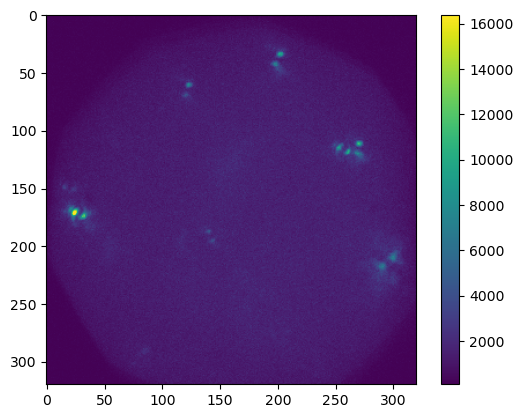

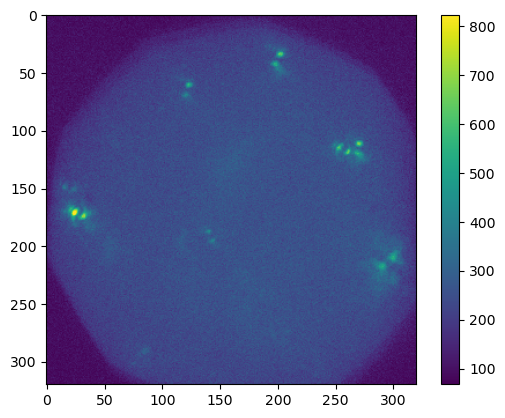

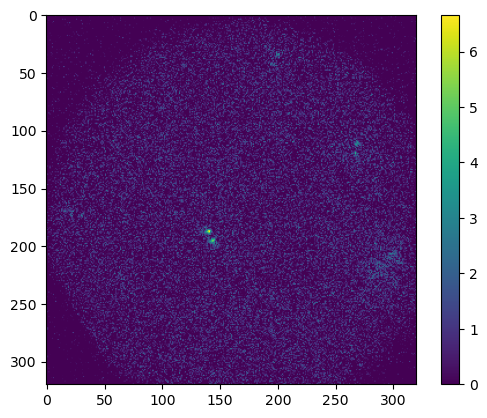

In [49]:
from PYME.localization.remFitBuf import fitTask

frame_num = 1500

test_frame = np.squeeze(im.data_xytc[:,:,frame_num,0])
bg_subbed_frame = np.squeeze(bg_sub.data_xytc[:,:,frame_num,0])

test_frame[test_frame<0] = 0
bg_subbed_frame[bg_subbed_frame<0] = 0

plt.figure()
plt.imshow(test_frame)
plt.colorbar()


sigma = np.squeeze(fitTask.calcSigma(im.mdh, test_frame.astype('f')))
plt.figure()
plt.imshow(sigma)
plt.colorbar()

plt.figure()
plt.imshow(bg_subbed_frame/sigma)
plt.colorbar()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000199A26AB688>


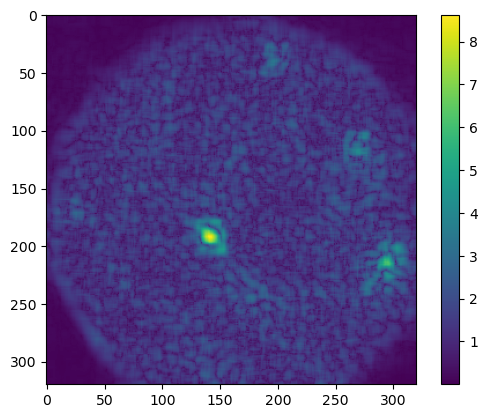

In [59]:

# plt.figure()
# plt.imshow(im.data_xytc[:,:,test_frame,0])
# plt.colorbar()

strength_image, angle_image = detector.filter_frame(bg_subbed_frame/sigma)

plt.figure()
plt.imshow(strength_image)
plt.colorbar()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000199994D02C8>


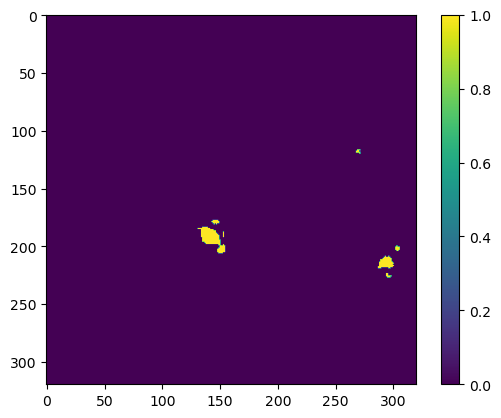

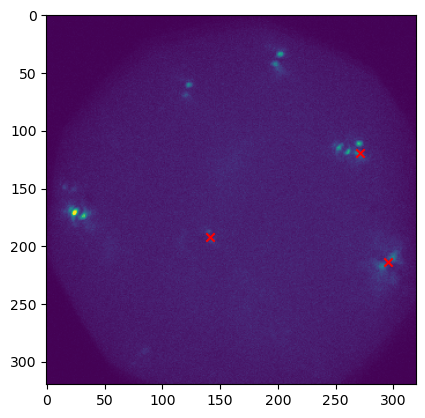

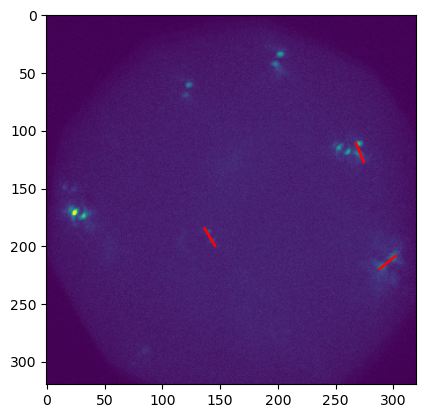

In [60]:
thresh = 4
plt.figure()
plt.imshow(strength_image>thresh)
plt.colorbar()

row, col, orientation = detector.extract_candidates(strength_image, angle_image, thresh)

plt.figure()
plt.imshow(np.squeeze(im.data_xytc[:,:,frame_num,0]))
plt.scatter(col, row, marker='x', c='red')
plt.show()

def lobe_estimate_from_center_pixel(x_pix, y_pix, orientation, lobe_sep_px):
    dx = np.cos(orientation) * lobe_sep_px
    dy = np.sin(orientation) * lobe_sep_px
    x1 = x_pix - dx
    y1 = y_pix - dy
    x2 = x_pix + dx
    y2 = y_pix + dy
    return x1, y1, x2, y2

x1, y1, x2, y2 = lobe_estimate_from_center_pixel(col, row, orientation, lobe_sep_px)

plt.figure()
plt.imshow(np.squeeze(im.data_xytc[:,:,frame_num,0]))
# plt.scatter(col, row, marker='x', c='red')
for ii in range(len(row)):
    plt.plot([x1, x2], [y1, y2], 'r')

plt.show()